# Transformer Encoder デモ

このノートブックでは、Transformer Encoderの構造を学びます。

## Encoderの構成要素

Encoderは以下の要素で構成されます：

1. **Multi-Head Attention** - トークン間の関係を捉える
2. **Feed Forward Network** - 非線形変換を適用
3. **Layer Normalization** - 学習を安定化
4. **Residual Connection** - 勾配の流れを改善

```
入力
  ↓
┌─────────────────┐
│ Multi-Head      │
│ Self-Attention  │
└────────┬────────┘
  ↓      │
Add & Norm ←─┘ (残差接続)
  ↓
┌─────────────────┐
│ Feed Forward    │
│ Network         │
└────────┬────────┘
  ↓      │
Add & Norm ←─┘ (残差接続)
  ↓
出力
```

In [1]:
import sys
sys.path.append('..')

# モジュールの自動リロード（開発中に便利）
import importlib
import src.encoder
import src.attention
import src.feed_forward
importlib.reload(src.encoder)
importlib.reload(src.attention)
importlib.reload(src.feed_forward)

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from src.encoder import (
    LayerNorm, ResidualConnection, 
    EncoderLayer, Encoder, TransformerEncoder
)
from src.attention import MultiHeadAttention
from src.feed_forward import FeedForward

# 日本語フォント設定（macOS）
plt.rcParams['font.family'] = 'Hiragino Sans'

# 再現性のためのシード設定
torch.manual_seed(42)

## 1. Layer Normalization（層正規化）

### なぜ正規化が必要か？

深いネットワークでは、各層の入力分布が変化し（内部共変量シフト）、学習が不安定になります。
Layer Normalizationは各サンプルの特徴次元に沿って正規化することで、この問題を緩和します。

### 数式

$$\text{LayerNorm}(x) = \gamma \cdot \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta$$

- $\mu$: 特徴次元の平均
- $\sigma^2$: 特徴次元の分散
- $\gamma, \beta$: 学習可能なパラメータ

In [2]:
# Layer Normalizationの動作確認

d_model = 64
batch_size = 2
seq_len = 5

# 様々なスケールの入力
x = torch.randn(batch_size, seq_len, d_model) * 10  # スケールを大きく

layer_norm = LayerNorm(d_model)

with torch.no_grad():
    output = layer_norm(x)

print("Layer Normalizationの効果")
print("=" * 50)
print(f"入力の統計（位置0）:")
print(f"  平均: {x[0, 0].mean().item():.4f}")
print(f"  標準偏差: {x[0, 0].std().item():.4f}")
print(f"\n出力の統計（位置0）:")
print(f"  平均: {output[0, 0].mean().item():.4f}")
print(f"  標準偏差: {output[0, 0].std().item():.4f}")
print("\n→ 平均≈0、標準偏差≈1 に正規化される")

Layer Normalizationの効果
入力の統計（位置0）:
  平均: 0.3282
  標準偏差: 10.5747

出力の統計（位置0）:
  平均: 0.0000
  標準偏差: 1.0000

→ 平均≈0、標準偏差≈1 に正規化される


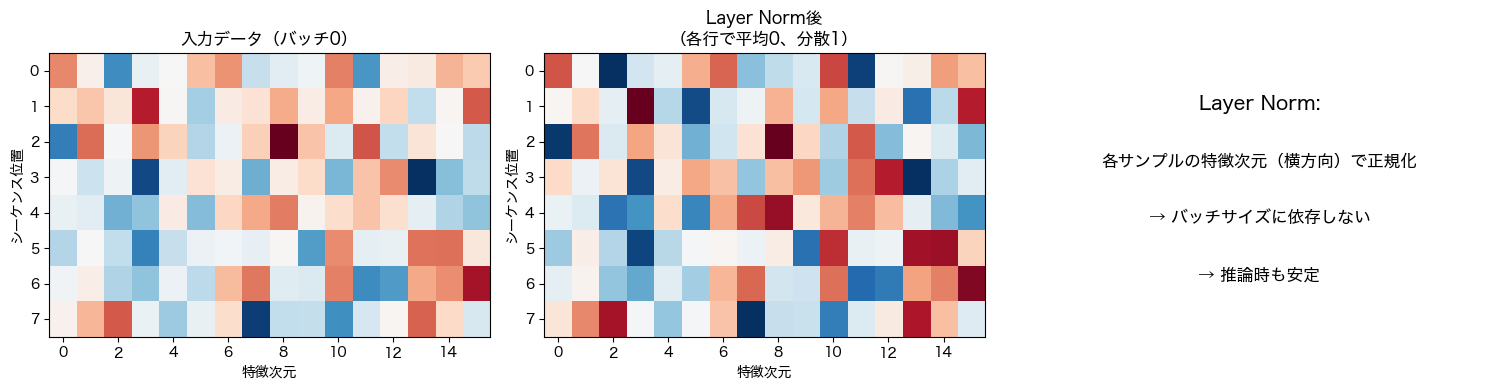

In [3]:
# Layer Norm vs Batch Normの違いを可視化

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# サンプルデータ
data = torch.randn(4, 8, 16)  # [batch, seq_len, d_model]

# 入力データを可視化
axes[0].imshow(data[0].numpy(), cmap='RdBu', aspect='auto')
axes[0].set_title('入力データ（バッチ0）')
axes[0].set_xlabel('特徴次元')
axes[0].set_ylabel('シーケンス位置')

# Layer Norm（特徴次元で正規化）
ln = LayerNorm(16)
with torch.no_grad():
    ln_output = ln(data)
axes[1].imshow(ln_output[0].numpy(), cmap='RdBu', aspect='auto', vmin=-2, vmax=2)
axes[1].set_title('Layer Norm後\n（各行で平均0、分散1）')
axes[1].set_xlabel('特徴次元')
axes[1].set_ylabel('シーケンス位置')

# 正規化の方向を図示
axes[2].text(0.5, 0.8, 'Layer Norm:', fontsize=14, ha='center', transform=axes[2].transAxes)
axes[2].text(0.5, 0.6, '各サンプルの特徴次元（横方向）で正規化', fontsize=12, ha='center', transform=axes[2].transAxes)
axes[2].text(0.5, 0.4, '→ バッチサイズに依存しない', fontsize=12, ha='center', transform=axes[2].transAxes)
axes[2].text(0.5, 0.2, '→ 推論時も安定', fontsize=12, ha='center', transform=axes[2].transAxes)
axes[2].axis('off')

plt.tight_layout()
plt.show()

## 2. Residual Connection（残差接続）

### なぜ残差接続が必要か？

深いネットワークでは：
1. **勾配消失**: 逆伝播で勾配が小さくなりすぎる
2. **最適化困難**: 恒等写像を学習するのが難しい

残差接続はこれらを解決します：

$$\text{output} = x + F(x)$$

- $F(x) = 0$ を学習すれば恒等写像
- 勾配が直接流れるパス（ショートカット）を提供

In [4]:
# 残差接続の効果を確認

d_model = 64

# 入力
x = torch.randn(1, 5, d_model)

# 残差接続
residual = ResidualConnection(d_model, dropout=0.0)

# 何もしないサブレイヤー（恒等関数）
identity = lambda x: x * 0  # 出力を0にする

with torch.no_grad():
    output = residual(x, identity)

print("残差接続の効果")
print("=" * 50)
print(f"サブレイヤー: F(x) = 0（何もしない）")
print(f"\n出力 = LayerNorm(x + F(x)) = LayerNorm(x)")
print(f"\n→ サブレイヤーが0を出力しても、入力が保持される")

残差接続の効果
サブレイヤー: F(x) = 0（何もしない）

出力 = LayerNorm(x + F(x)) = LayerNorm(x)

→ サブレイヤーが0を出力しても、入力が保持される


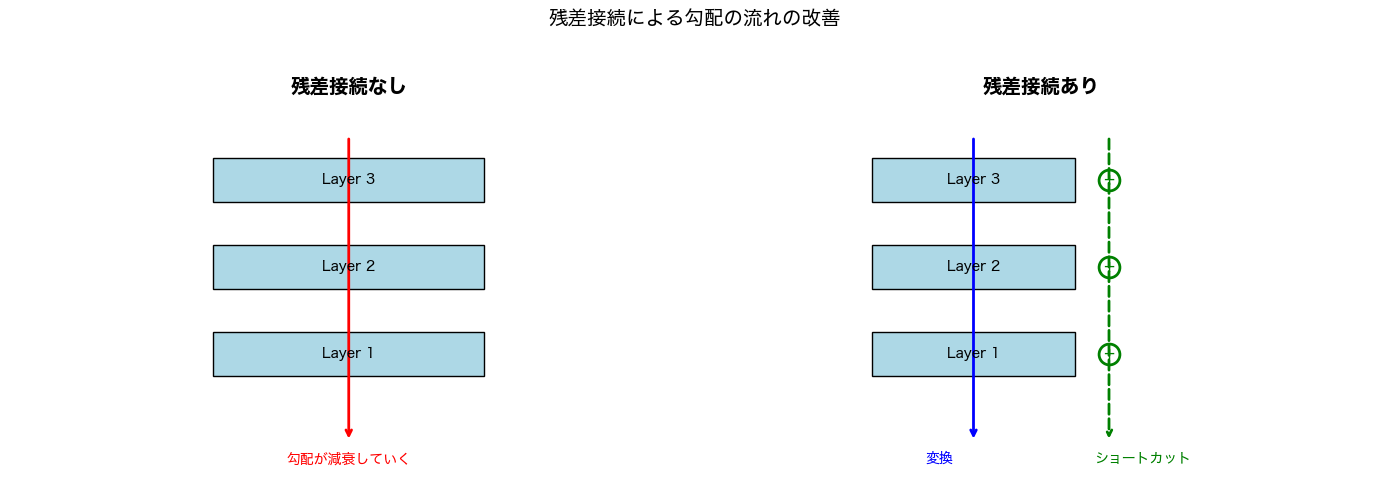

In [5]:
# 残差接続による勾配の流れを可視化

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 残差接続なし
axes[0].text(0.5, 0.9, '残差接続なし', fontsize=14, ha='center', fontweight='bold')
axes[0].annotate('', xy=(0.5, 0.1), xytext=(0.5, 0.8),
                arrowprops=dict(arrowstyle='->', color='red', lw=2))
for i, y in enumerate([0.7, 0.5, 0.3]):
    axes[0].add_patch(plt.Rectangle((0.3, y-0.05), 0.4, 0.1, 
                                     facecolor='lightblue', edgecolor='black'))
    axes[0].text(0.5, y, f'Layer {3-i}', ha='center', va='center')
axes[0].text(0.5, 0.05, '勾配が減衰していく', ha='center', color='red')
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 1)
axes[0].axis('off')

# 残差接続あり
axes[1].text(0.5, 0.9, '残差接続あり', fontsize=14, ha='center', fontweight='bold')
# メインパス
axes[1].annotate('', xy=(0.4, 0.1), xytext=(0.4, 0.8),
                arrowprops=dict(arrowstyle='->', color='blue', lw=2))
# ショートカットパス
axes[1].annotate('', xy=(0.6, 0.1), xytext=(0.6, 0.8),
                arrowprops=dict(arrowstyle='->', color='green', lw=2, linestyle='--'))
for i, y in enumerate([0.7, 0.5, 0.3]):
    axes[1].add_patch(plt.Rectangle((0.25, y-0.05), 0.3, 0.1, 
                                     facecolor='lightblue', edgecolor='black'))
    axes[1].text(0.4, y, f'Layer {3-i}', ha='center', va='center')
    # 加算記号
    axes[1].plot(0.6, y, 'o', markersize=15, color='white', 
                markeredgecolor='green', markeredgewidth=2)
    axes[1].text(0.6, y, '+', ha='center', va='center', fontsize=12, color='green')

axes[1].text(0.35, 0.05, '変換', ha='center', color='blue')
axes[1].text(0.65, 0.05, 'ショートカット', ha='center', color='green')
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)
axes[1].axis('off')

plt.suptitle('残差接続による勾配の流れの改善', fontsize=14)
plt.tight_layout()
plt.show()

## 3. Encoder Layer（1層分）

EncoderLayerは以下の2つのサブレイヤーで構成：

1. **Self-Attention + Add & Norm**
2. **FFN + Add & Norm**

In [6]:
# EncoderLayerの構造を確認

d_model = 64
num_heads = 4

encoder_layer = EncoderLayer(d_model, num_heads, dropout=0.0)

print("EncoderLayer の構造")
print("=" * 50)
print(encoder_layer)

# パラメータ数
params = sum(p.numel() for p in encoder_layer.parameters())
print(f"\nパラメータ数: {params:,}")

EncoderLayer の構造
EncoderLayer(
  (self_attention): MultiHeadAttention(
    (W_q): Linear(in_features=64, out_features=64, bias=False)
    (W_k): Linear(in_features=64, out_features=64, bias=False)
    (W_v): Linear(in_features=64, out_features=64, bias=False)
    (attention): ScaledDotProductAttention(
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (W_o): Linear(in_features=64, out_features=64, bias=False)
  )
  (feed_forward): FeedForward(
    (linear1): Linear(in_features=64, out_features=256, bias=True)
    (linear2): Linear(in_features=256, out_features=64, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (activation): ReLU()
  )
  (residual1): ResidualConnection(
    (norm): LayerNorm()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (residual2): ResidualConnection(
    (norm): LayerNorm()
    (dropout): Dropout(p=0.0, inplace=False)
  )
)

パラメータ数: 49,728


In [7]:
# EncoderLayerの順伝播を追跡

batch_size = 1
seq_len = 5
d_model = 64
num_heads = 4

x = torch.randn(batch_size, seq_len, d_model)
encoder_layer = EncoderLayer(d_model, num_heads, dropout=0.0)

print("EncoderLayer 順伝播の流れ")
print("=" * 50)
print(f"入力: {x.shape}")

# 手動で各ステップを実行
with torch.no_grad():
    # Step 1: Self-Attention
    attn_output, attn_weights = encoder_layer.self_attention(x, x, x)
    print(f"\n1. Self-Attention出力: {attn_output.shape}")
    print(f"   Attention重み: {attn_weights.shape}")
    
    # Step 2: 残差接続 + LayerNorm
    after_attn = encoder_layer.residual1.norm(x + attn_output)
    print(f"\n2. 残差接続 + LayerNorm: {after_attn.shape}")
    
    # Step 3: FFN
    ffn_output = encoder_layer.feed_forward(after_attn)
    print(f"\n3. FFN出力: {ffn_output.shape}")
    
    # Step 4: 残差接続 + LayerNorm
    final_output = encoder_layer.residual2.norm(after_attn + ffn_output)
    print(f"\n4. 最終出力: {final_output.shape}")

# 全体を通して実行
with torch.no_grad():
    output = encoder_layer(x)
print(f"\n直接実行の出力: {output.shape}")

EncoderLayer 順伝播の流れ
入力: torch.Size([1, 5, 64])

1. Self-Attention出力: torch.Size([1, 5, 64])
   Attention重み: torch.Size([1, 4, 5, 5])

2. 残差接続 + LayerNorm: torch.Size([1, 5, 64])

3. FFN出力: torch.Size([1, 5, 64])

4. 最終出力: torch.Size([1, 5, 64])

直接実行の出力: torch.Size([1, 5, 64])


/var/folders/2g/vjpf8_jn6dq3z6qmf68msfwm0000gn/T/ipykernel_47260/2561423321.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


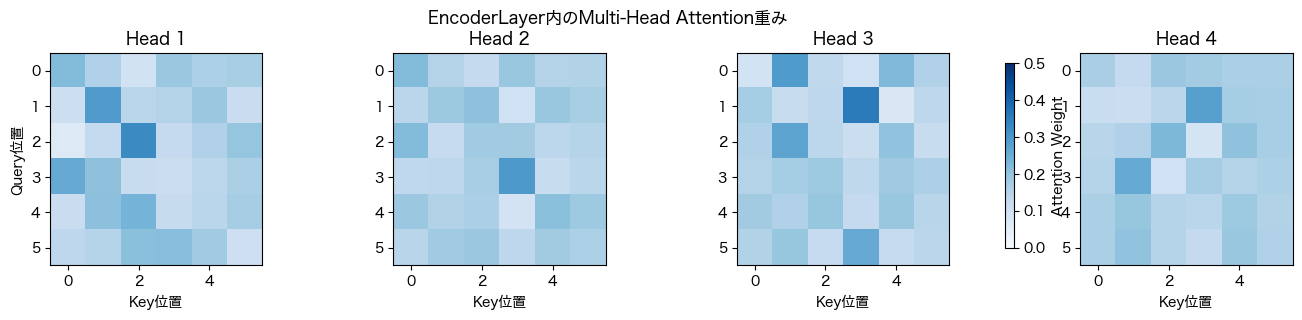

In [8]:
# Attention重みの可視化

# 簡単な入力（各位置に異なる特徴）
x = torch.randn(1, 6, d_model)

encoder_layer = EncoderLayer(d_model, num_heads, dropout=0.0)

with torch.no_grad():
    # Attentionの重みを取得
    _, attn_weights = encoder_layer.self_attention(x, x, x)

# ヘッドごとの重みを可視化（カラーバー用のスペースを確保）
fig, axes = plt.subplots(1, num_heads, figsize=(15, 3))
fig.subplots_adjust(right=0.9)  # 右側にスペースを確保

for h in range(num_heads):
    im = axes[h].imshow(attn_weights[0, h].numpy(), cmap='Blues', vmin=0, vmax=0.5)
    axes[h].set_title(f'Head {h+1}')
    axes[h].set_xlabel('Key位置')
    if h == 0:
        axes[h].set_ylabel('Query位置')

plt.suptitle('EncoderLayer内のMulti-Head Attention重み', fontsize=12, y=1.02)

# カラーバーを右端に配置
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, label='Attention Weight')
plt.show()

## 4. Encoder（全体）

Encoderは複数のEncoderLayerを積み重ねた構造です。

```
入力埋め込み
    ↓
+ Position Encoding
    ↓
┌─────────────────┐
│ Encoder Layer 1 │
├─────────────────┤
│ Encoder Layer 2 │
├─────────────────┤
│      ...        │
├─────────────────┤
│ Encoder Layer N │
└─────────────────┘
    ↓
出力
```

In [9]:
# Encoderの構造を確認

d_model = 64
num_heads = 4
num_layers = 3  # 3層のEncoder

encoder = Encoder(d_model, num_heads, num_layers, dropout=0.0)

print("Encoder の構造")
print("=" * 50)
print(f"層数: {num_layers}")
print(f"d_model: {d_model}")
print(f"num_heads: {num_heads}")

# パラメータ数
total_params = sum(p.numel() for p in encoder.parameters())
layer_params = sum(p.numel() for p in encoder.layers[0].parameters())

print(f"\n1層あたりのパラメータ: {layer_params:,}")
print(f"全体のパラメータ: {total_params:,}")

Encoder の構造
層数: 3
d_model: 64
num_heads: 4

1層あたりのパラメータ: 49,728
全体のパラメータ: 149,312


In [10]:
# Encoderの順伝播

batch_size = 2
seq_len = 10

# 入力（通常はToken Embeddingの出力）
x = torch.randn(batch_size, seq_len, d_model)

with torch.no_grad():
    output = encoder(x)

print("Encoder 順伝播")
print("=" * 50)
print(f"入力: {x.shape}")
print(f"出力: {output.shape}")
print(f"\n→ 形状は変わらない（各位置の特徴が変換される）")

Encoder 順伝播
入力: torch.Size([2, 10, 64])
出力: torch.Size([2, 10, 64])

→ 形状は変わらない（各位置の特徴が変換される）


In [11]:
# 各層を通過する際の特徴の変化を追跡

x = torch.randn(1, seq_len, d_model)

# Position Encoding適用後
with torch.no_grad():
    x_with_pe = encoder.pos_encoding(x)
    
    layer_outputs = [x_with_pe]
    current = x_with_pe
    
    for i, layer in enumerate(encoder.layers):
        current = layer(current)
        layer_outputs.append(current)

# 各層の出力の統計を確認
print("各層の出力の統計")
print("=" * 50)
print(f"{'層':>10} | {'平均':>10} | {'標準偏差':>10} | {'最大値':>10}")
print("-" * 50)

for i, output in enumerate(layer_outputs):
    mean = output.mean().item()
    std = output.std().item()
    max_val = output.abs().max().item()
    layer_name = "入力+PE" if i == 0 else f"Layer {i}"
    print(f"{layer_name:>10} | {mean:>10.4f} | {std:>10.4f} | {max_val:>10.4f}")

print("\n→ Layer Normalizationにより、各層の出力が安定している")

各層の出力の統計
         層 |         平均 |       標準偏差 |        最大値
--------------------------------------------------
     入力+PE |     0.4467 |     1.1263 |     3.7614
   Layer 1 |     0.0000 |     0.9929 |     3.3442
   Layer 2 |     0.0000 |     0.9929 |     2.8424
   Layer 3 |     0.0000 |     0.9929 |     2.9943

→ Layer Normalizationにより、各層の出力が安定している


## 5. TransformerEncoder（埋め込み層を含む完全版）

実際のタスクでは、トークンID → Embedding → Encoder という流れになります。

In [12]:
# TransformerEncoder（完全版）

vocab_size = 10000  # 語彙サイズ
d_model = 128
num_heads = 8
num_layers = 4

transformer_encoder = TransformerEncoder(
    vocab_size=vocab_size,
    d_model=d_model,
    num_heads=num_heads,
    num_layers=num_layers,
    dropout=0.1
)

print("TransformerEncoder の構成")
print("=" * 50)
print(f"語彙サイズ: {vocab_size:,}")
print(f"d_model: {d_model}")
print(f"num_heads: {num_heads}")
print(f"num_layers: {num_layers}")

total_params = sum(p.numel() for p in transformer_encoder.parameters())
embedding_params = vocab_size * d_model
encoder_params = total_params - embedding_params

print(f"\nパラメータ数:")
print(f"  Embedding: {embedding_params:,} ({embedding_params/total_params*100:.1f}%)")
print(f"  Encoder:   {encoder_params:,} ({encoder_params/total_params*100:.1f}%)")
print(f"  合計:      {total_params:,}")

TransformerEncoder の構成
語彙サイズ: 10,000
d_model: 128
num_heads: 8
num_layers: 4

パラメータ数:
  Embedding: 1,280,000 (61.8%)
  Encoder:   791,296 (38.2%)
  合計:      2,071,296


In [13]:
# トークンIDを入力として使用

batch_size = 2
seq_len = 20

# ランダムなトークンID（0はパディング）
src = torch.randint(1, vocab_size, (batch_size, seq_len))
# 最後の5トークンをパディングに
src[:, -5:] = 0

print("入力トークンID（バッチ0）:")
print(src[0].numpy())

with torch.no_grad():
    output = transformer_encoder(src)

print(f"\n入力形状: {src.shape}")
print(f"出力形状: {output.shape}")

入力トークンID（バッチ0）:
[4203 5159 4550 8779 7864  504 4950 1186 1382 4493 9758 5738 2903 9872
 1025    0    0    0    0    0]

入力形状: torch.Size([2, 20])
出力形状: torch.Size([2, 20, 128])


## 6. パディングマスク

可変長のシーケンスを扱う際、短いシーケンスはパディングで埋められます。
パディング位置はAttentionで無視されるべきです。

In [14]:
# パディングマスクの動作確認

# パディングあり/なしで比較
src_no_pad = torch.randint(1, vocab_size, (1, 10))  # パディングなし
src_with_pad = src_no_pad.clone()
src_with_pad[0, 7:] = 0  # 最後の3トークンをパディング

print("パディングなし:", src_no_pad[0].numpy())
print("パディングあり:", src_with_pad[0].numpy())

# パディングマスクを確認
pad_mask = (src_with_pad != 0)
print(f"\nパディングマスク: {pad_mask[0].numpy()}")
print("（Trueの位置がAttentionで考慮される）")

パディングなし: [3805 5558 4319 5484 9247 3089 7750 4048  783 4495]
パディングあり: [3805 5558 4319 5484 9247 3089 7750    0    0    0]

パディングマスク: [ True  True  True  True  True  True  True False False False]
（Trueの位置がAttentionで考慮される）


## 7. 実際のモデルサイズ比較

有名なモデルのEncoder部分のパラメータ数を比較します。

In [15]:
# 様々なサイズのEncoderを比較

configs = [
    {"name": "Tiny", "d_model": 128, "num_heads": 2, "num_layers": 2, "vocab": 10000},
    {"name": "Small", "d_model": 256, "num_heads": 4, "num_layers": 4, "vocab": 30000},
    {"name": "Base (BERT)", "d_model": 768, "num_heads": 12, "num_layers": 12, "vocab": 30522},
    {"name": "Large (BERT)", "d_model": 1024, "num_heads": 16, "num_layers": 24, "vocab": 30522},
]

print("モデルサイズ比較")
print("=" * 70)
print(f"{'モデル':>15} | {'d_model':>8} | {'layers':>6} | {'パラメータ数':>15}")
print("-" * 70)

for cfg in configs:
    encoder = TransformerEncoder(
        vocab_size=cfg["vocab"],
        d_model=cfg["d_model"],
        num_heads=cfg["num_heads"],
        num_layers=cfg["num_layers"]
    )
    params = sum(p.numel() for p in encoder.parameters())
    print(f"{cfg['name']:>15} | {cfg['d_model']:>8} | {cfg['num_layers']:>6} | {params:>15,}")

print("\n注: 実際のBERTはさらにタスク固有のヘッドを含む")

モデルサイズ比較
            モデル |  d_model | layers |          パラメータ数
----------------------------------------------------------------------
           Tiny |      128 |      2 |       1,675,776
          Small |      256 |      4 |      10,835,456
    Base (BERT) |      768 |     12 |     108,460,032
   Large (BERT) |     1024 |     24 |     333,467,648

注: 実際のBERTはさらにタスク固有のヘッドを含む


## 8. まとめ

### Encoderの構成要素

| 要素 | 役割 |
|------|------|
| **Token Embedding** | トークンIDを密ベクトルに変換 |
| **Position Encoding** | 位置情報を付与 |
| **Multi-Head Attention** | トークン間の関係を捉える |
| **Feed Forward Network** | 非線形変換を適用 |
| **Layer Normalization** | 学習を安定化 |
| **Residual Connection** | 勾配の流れを改善 |

### Encoder Layerの構造

```
x → [Self-Attention] → Add & Norm → [FFN] → Add & Norm → 出力
      ↑__________________|            ↑________|          
         残差接続                       残差接続
```

### 次のステップ
- Decoder の実装
- Cross-Attention（Encoder-Decoder間のAttention）
- 完全なTransformerモデル

In [16]:
# 学習パラメータの確認

print("Encoder パラメータ一覧")
print("=" * 60)

d_model = 64
num_heads = 4
num_layers = 2

encoder = Encoder(d_model, num_heads, num_layers)

print(f"\n【Encoder全体】 ({num_layers}層)")
total = 0
for name, param in encoder.named_parameters():
    print(f"  {name}: {param.shape} = {param.numel():,}")
    total += param.numel()
print(f"\n  合計: {total:,} パラメータ")

Encoder パラメータ一覧

【Encoder全体】 (2層)
  layers.0.self_attention.W_q.weight: torch.Size([64, 64]) = 4,096
  layers.0.self_attention.W_k.weight: torch.Size([64, 64]) = 4,096
  layers.0.self_attention.W_v.weight: torch.Size([64, 64]) = 4,096
  layers.0.self_attention.W_o.weight: torch.Size([64, 64]) = 4,096
  layers.0.feed_forward.linear1.weight: torch.Size([256, 64]) = 16,384
  layers.0.feed_forward.linear1.bias: torch.Size([256]) = 256
  layers.0.feed_forward.linear2.weight: torch.Size([64, 256]) = 16,384
  layers.0.feed_forward.linear2.bias: torch.Size([64]) = 64
  layers.0.residual1.norm.gamma: torch.Size([64]) = 64
  layers.0.residual1.norm.beta: torch.Size([64]) = 64
  layers.0.residual2.norm.gamma: torch.Size([64]) = 64
  layers.0.residual2.norm.beta: torch.Size([64]) = 64
  layers.1.self_attention.W_q.weight: torch.Size([64, 64]) = 4,096
  layers.1.self_attention.W_k.weight: torch.Size([64, 64]) = 4,096
  layers.1.self_attention.W_v.weight: torch.Size([64, 64]) = 4,096
  layers.1.self